**ETAPA 1. Descripción del Proyecto**

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

**Para iniciar se deben cargar todas las librerías que se van a usar durante el proyecto.**

In [165]:
# Cargar todas las librerías
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re
import numpy as np
import datetime as dt
import scipy.stats as stats
import math as mth

**El propósito de definir las etapas del embudo de eventos al inicio del notebook es mantener el código organizado, evitar la repetición y asegurar la consistencia en todo el análisis. Este lo utilice en la ETAPA 3 Análisis exploratorio en el paso 2 para ayudar a responder las preguntas 3 y 4 de ese apartado.**

In [166]:
# Definir las etapas del embudo en orden lógico
funnel_stages = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful',
    'Tutorial'
]

**En este sección reuní el dataframe, la función .read_csv permite leer el archivo cargado.**

In [167]:
# leer el conjunto de datos en el DataFrame
df_logs_experiment = pd.read_csv('./datasets/logs_exp_us.csv', delimiter='\t')

**Uso las funciones info() y head() para explorar visualmente el dataframe en cuestión con el fin de analizar que campos tiene, sus características, y los detalles que no sean funcionales corregir, para hacer un análisis acorde e ideal a lo solicitado.**

In [168]:
# Imprime la información general/resumida sobre el DataFrame experimento de registros
df_logs_experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [169]:
# Imprimir una muestra de los datos para el experimento de registros
df_logs_experiment.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**ETAPA 2. Preprocesamiento de los datos**

**El objetivo aquí es preparar los datos para que sean analizados. Para ello hay que resolver cualquier problema que haya con los encabezados con el fin preservar las reglas del buen estilo, luego verificar y en su caso corregir los tipos de datos de cada columna, identificar los valores ausentes y en su caso completar dichos valores, y finalmente identificar si fuera el caso eliminar los valores duplicados.**

**ACCIONES A LLEVAR A CABO EN EL PREPROCESAMIENTO DE LOS DATOS DEL DATAFRAME VISITAS**

a. Cambiar todas las columnas a minúsculas y aplicar la regla de snake_case a los campos que lo requieran con el fin de preservar las reglas del buen estilo todo ello mediante una función.

b. Calcular el número de valores ausentes.

c. Corregir errores y preparar los datos de la columna EVENT TIMESTAMP que incluye: convertir de tipo int64 a tipo datetime64[ns] la columna.

d. Revisar y eliminar duplicados.

e. Preparar los datos de la columna EVENT NAME que incluye: ver cuántas visitas hay por evento.

f. Preparar los datos de la columna EXP ID que incluye: ver cuántos eventos hay por grupo de control y por grupo de prueba.

g. Calcular con las funciones MIN y MAX la fecha en que inicia el primer evento y la fecha en que termina el último evento.

h. Enriquecer los datos a partir de la columna EVENT TIMESTAMP para generar laS columnaS EVENT DATE y EVENT TIME.

**Tratamiento de las columnas**

In [170]:
# Mostrar los nombres de las columnas
df_logs_experiment.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [171]:
# Generar una función para convertir los nombres de columnas a snake_case con el fin de presercar las reglas del buen estilo
def to_snake_case(column):
    snake1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column)
    snake2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', snake1)
    return snake2.lower()

In [172]:
# Generar una función para aplicar la función TO SNAKE CASE a cada columna del dataframe
def dataframe_columns_to_snake_case(df):
    df.columns = [to_snake_case(col) for col in df.columns]
    return df

In [173]:
# Aplicar la función al dataframe experimento de registros
df_logs_experiment = dataframe_columns_to_snake_case(df_logs_experiment)

In [174]:
# Comprobar el resultado: la lista de encabezados
df_logs_experiment.head(0)

,event_name,device_id_hash,event_timestamp,exp_id


**Tratamiento de los valores ausentes**

Para este conjunto de datos caso de estudio no se procederá a realizar algún tratamiento de los valores ausentes ya que como se puede ver después de generar el código y ejecutar el mismo en la caja CODE de abajo, el dataframe EXPERIMENTO DE REGISTROS no cuenta con información de este tipo en ninguna de sus columnas.

In [175]:
# Calcular el número de valores ausentes
df_logs_experiment.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

**Preparar los datos de la columna EVENT TIMESTAMP**

In [176]:
# Convertir de tipo int64 a tipo datetime64[ns] la columna
df_logs_experiment['event_timestamp'] = pd.to_datetime(df_logs_experiment['event_timestamp'], unit='s')

In [177]:
# Imprimir la información general actualizada
df_logs_experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


**Revisar y eliminar duplicados**

In [178]:
# Revisar si hay valores duplicados
df_logs_experiment.duplicated().sum()

413

In [179]:
# Crear un filtro para las filas no duplicadas
filtered_df_logs_experiment = ~df_logs_experiment.duplicated()

In [180]:
# Aplicar el filtra al dataframe experimento de registros limpio
df_logs_experiment_clean  = df_logs_experiment[filtered_df_logs_experiment]

In [181]:
# Imprimir la información general actualizada
df_logs_experiment_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


**Preparar los datos de la columna EVENT NAME**

In [182]:
# Ver cuántas visitas hay por evento
df_logs_experiment_clean.value_counts('event_name')

event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64

**Preparar los datos de la columna EXP ID**

In [183]:
# Ver cuántos eventos hay por grupo de control y por grupo de prueba
df_logs_experiment_clean.value_counts('exp_id')

exp_id
248    85582
246    80181
247    77950
Name: count, dtype: int64

In [184]:
# Calcular con las funciones MIN y MAX la fecha en que inicia el primer evento y la fecha en que termina el último evento
print(df_logs_experiment_clean['event_timestamp'].min()) 
print(df_logs_experiment_clean['event_timestamp'].max())

2019-07-25 04:43:36
2019-08-07 21:15:17


**Enriquecer los datos**

In [185]:
# Enriquecer a partir de la columna event_timestamp por fecha y convertir de tipo object a tipo datetime64[ns] la columna
df_logs_experiment_clean = df_logs_experiment_clean.assign(
    event_date=df_logs_experiment_clean['event_timestamp'].dt.date.astype('datetime64[ns]')
)

In [186]:
# Imprimir una muestra de los datos para el experimento de registros limpio después de enriquecer el dataframe
df_logs_experiment_clean.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**ETAPA 3. Análisis exploratorio**

**Responder a las preguntas del negocio**

**Paso 1. Estudiar y comprobar los datos**

# ¿Cuántos eventos hay en los registros?

In [187]:
# Calcular los eventos por día y cambiar el nombre a las columnas
logged_events = df_logs_experiment_clean.groupby('event_date')['event_name'].count().reset_index()
logged_events.columns = ['event_date', 'events']

In [188]:
# Imprimir los datos
logged_events

,event_date,events
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


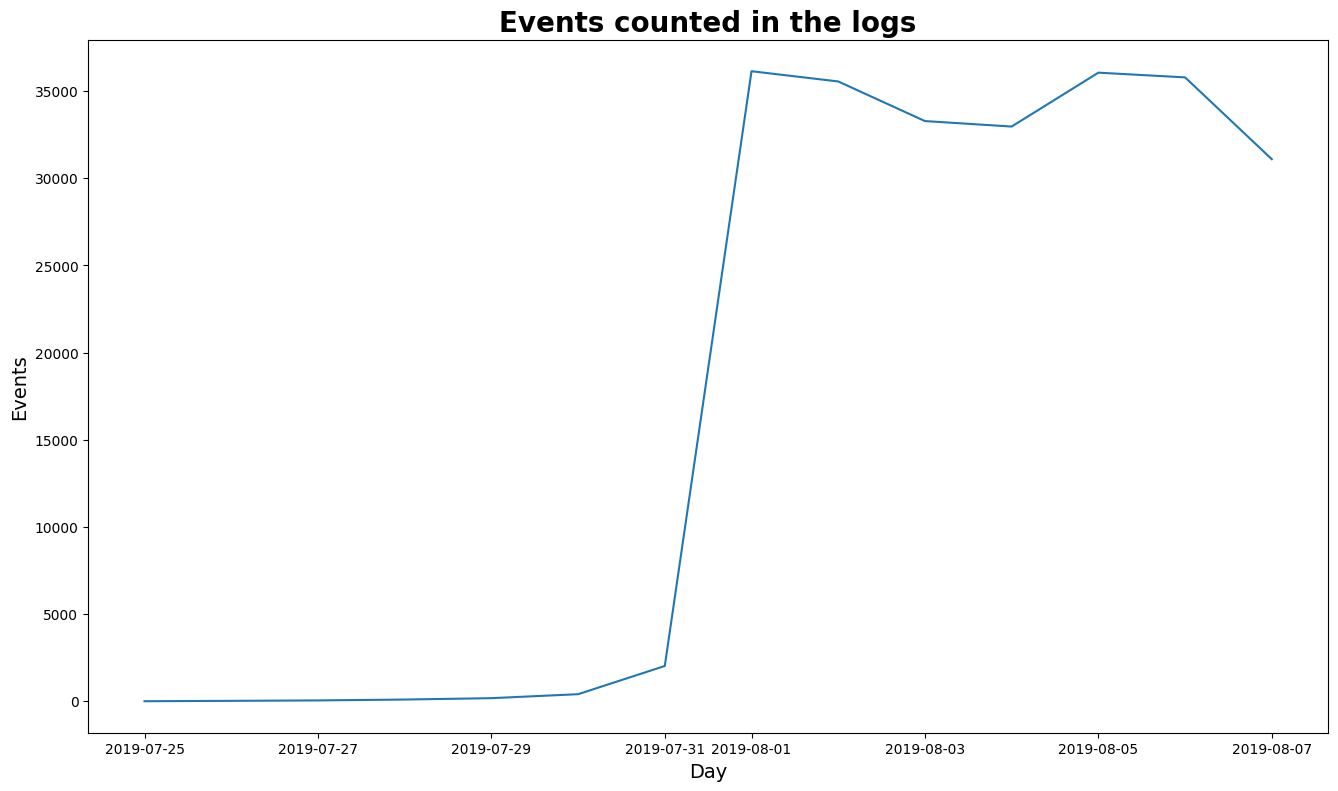

In [189]:
# Graficar los datos con la librería Seaborn
plt.figure(figsize=(16, 9))
sns.lineplot(x='event_date', y='events', data=logged_events)
plt.title('Events counted in the logs', fontsize=20, weight='bold')
plt.xlabel('Day', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.show()

In [190]:
# Calcular el número total de eventos de todo el periodo
print(f"El número total de eventos en todo el periodo es: {logged_events['events'].sum()}")

El número total de eventos en todo el periodo es: 243713


**Conclusiones**

- Se puede visualizar en el gráfico de líneas que los primeros días que comprenden del 25 de Julio al 31 de Julio de 2019 el número de eventos es muy bajo y constante. Esto indica que durante estos días no hubo cambios significativos o actividad relevante.


- Otro aspecto importante a tomar en cuenta es que a partir del 1 de agosto se observa un aumento significativo en el número de eventos, alcanzando un pico de alrededor de 36000 eventos. Este incremento podría deberse a un cambio importante en el sistema como una actualización, o un evento externo que genero más actividad.


- Finalmente se puede ver que después del pico elevado que se tuvo, el número de eventos se mantuvo alto, pero con fluctuaciones hasta el 7 de agosto de 2019. Esto indica que, aunque sigue siendo alta, hay variaciones que podrían estar relacionadas factores diarios o semanales.

# ¿Cuántos usuarios hay en los registros?

In [191]:
# Calcular los usuarios únicos por día y cambiar el nombre a las columnas
logged_users = df_logs_experiment_clean.groupby('event_date')['device_id_hash'].nunique().reset_index()
logged_users.columns = ['event_date', 'users']

In [192]:
# Imprimir los datos
logged_users

,event_date,users
0,2019-07-25,7
1,2019-07-26,22
2,2019-07-27,39
3,2019-07-28,69
4,2019-07-29,135
5,2019-07-30,296
6,2019-07-31,924
7,2019-08-01,3703
8,2019-08-02,3647
9,2019-08-03,3482


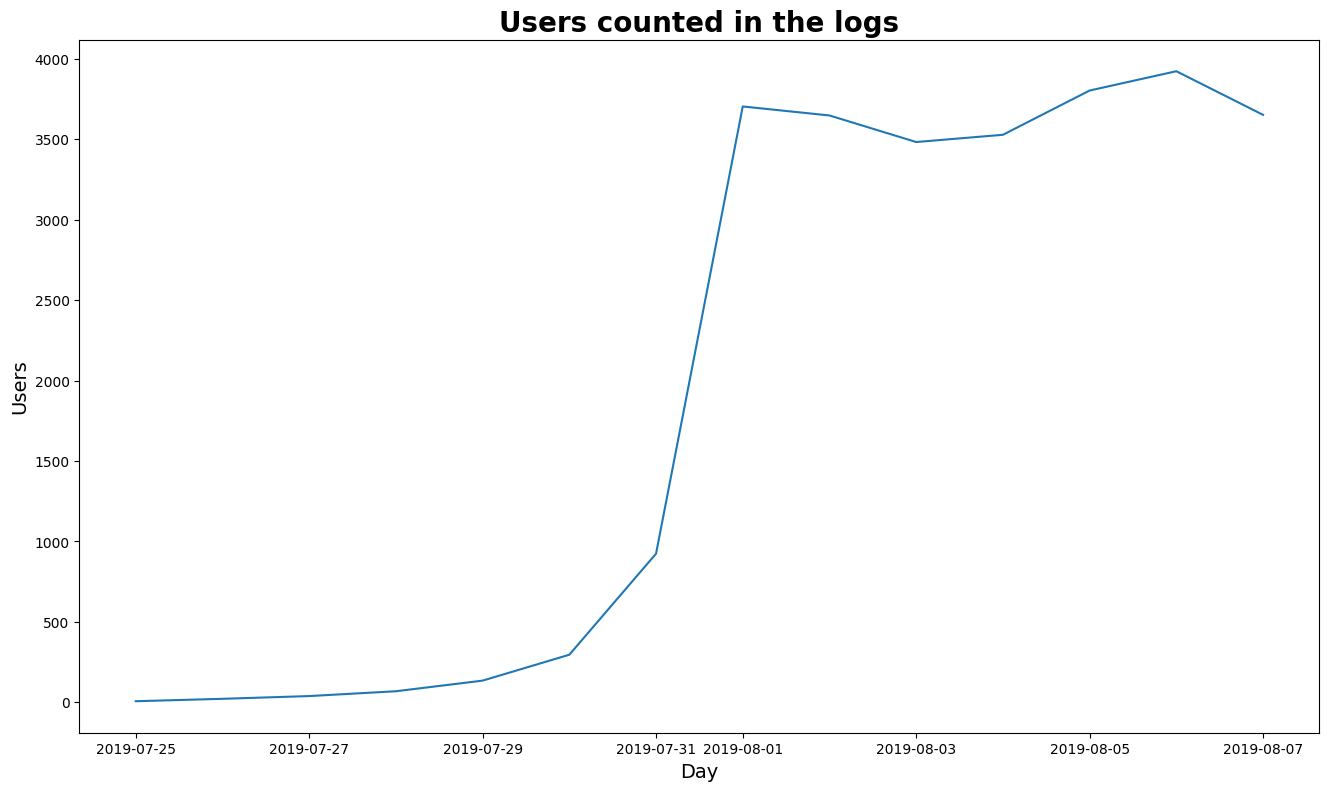

In [193]:
# Graficar los datos con la librería Seaborn
plt.figure(figsize=(16, 9))
sns.lineplot(x='event_date', y='users', data=logged_users)
plt.title('Users counted in the logs', fontsize=20, weight='bold')
plt.xlabel('Day', fontsize=14)
plt.ylabel('Users', fontsize=14)
plt.show()

In [194]:
# Calcular el número total de usuarios únicos de todo el periodo
print(f"El número total de usuarios únicos en todo el periodo es: {logged_users['users'].sum()}")

El número total de usuarios únicos en todo el periodo es: 27226


**Conclusiones**

- Se puede ver en la gráfica de líneas que del 25 de Agosto al 31 de Agosto de 2019, el número de usuarios se mantuvo relativamente bajo, con un ligero aumento el 31 de Agosto.


- A partir del 1 de Agosto, se observa un aumento significativo en el número de usuarios, alcanzado un pico significativo ese día.


- Después del 1 de Agosto se puede visualizar, que el número de usuarios se estabiliza en un rango alto, con pequeñas fluctuaciones, hasta el 7 de Agosto de 2019. 

# ¿Cuál es el promedio de eventos por usuario?

In [195]:
# Crear una tabla dinámica que muestre el número de usuarios asociados a cada evento
events_per_user = df_logs_experiment_clean.pivot_table(
    index= 'event_name',
    values = 'device_id_hash',
    aggfunc = 'nunique'
)

In [196]:
# Imprimir los datos de la tabla dinámica
events_per_user 

,device_id_hash
event_name,
CartScreenAppear,3749
MainScreenAppear,7439
OffersScreenAppear,4613
PaymentScreenSuccessful,3547
Tutorial,847


In [197]:
# Ordenar a partir de la columna DEVICE ID HASH en orden descendente, cambiar el nombre a la columna e imprimir el resultado
events_per_user_sorted = events_per_user.sort_values(by='device_id_hash', ascending=False)
events_per_user_sorted.columns = ['events_per_user']
events_per_user_sorted

,events_per_user
event_name,
MainScreenAppear,7439
OffersScreenAppear,4613
CartScreenAppear,3749
PaymentScreenSuccessful,3547
Tutorial,847


In [198]:
# Calcular el total de eventos por usuario
total_events_per_user = events_per_user_sorted['events_per_user'].sum()
print(f"El total de eventos por usuario: {total_events_per_user}")

El total de eventos por usuario: 20195


In [199]:
# Calcular el promedio de eventos por usuario único, cambiar el nombre a la columna e imprimir el resultado
average_events_per_user = events_per_user/len(df_logs_experiment_clean['device_id_hash'].unique())
average_events_per_user.columns = ['events_average']
average_events_per_user 

,events_average
event_name,
CartScreenAppear,0.496491
MainScreenAppear,0.985168
OffersScreenAppear,0.610912
PaymentScreenSuccessful,0.469739
Tutorial,0.112171


In [200]:
# Calcular el promedio de eventos por usuario
print(f"El promedio de eventos por usuario: {average_events_per_user ['events_average'].sum()}")

El promedio de eventos por usuario: 2.6744802012978415


**Conclusiones**

- Este promedio sugiere que hay un nivel de compromiso razonable por parte de los usuarios. No todos los usuarios están altamente activos, pero tampoco son completamente inactivos.


- Es probable que haya variación en la participación de los usuarios. Algunos usuarios pueden estar participando en más eventos, mientras que otros en menos.

# ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [201]:
# Encontrar que periodo de tiempo cubren los datos
print(
    f"El periodo de tiempo cubierto por los datos es desde " 
    f"{df_logs_experiment_clean['event_date'].min().strftime('%Y-%m-%d')} "
    f"hasta " 
    f"{df_logs_experiment_clean['event_date'].max().strftime('%Y-%m-%d')}")

El periodo de tiempo cubierto por los datos es desde 2019-07-25 hasta 2019-08-07


**Graficar los resultados obtenidos**

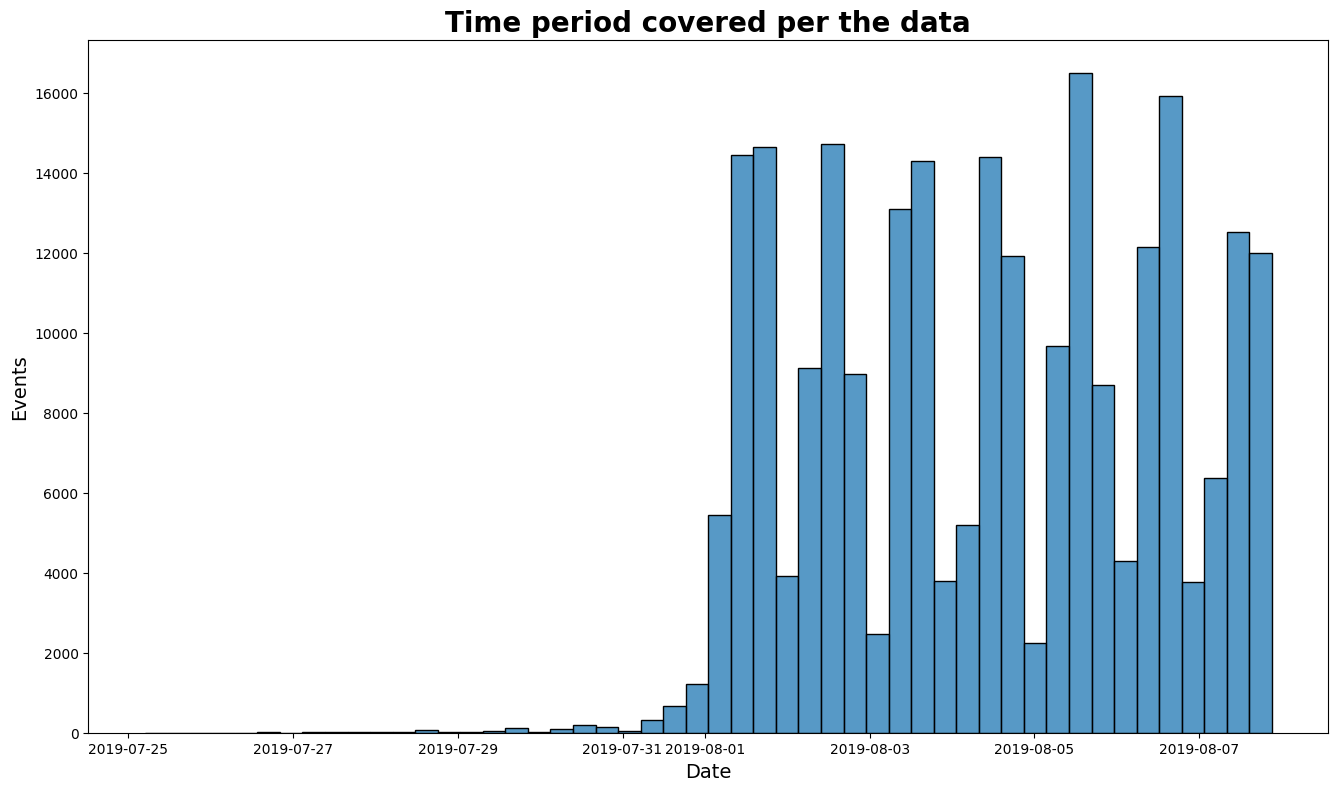

In [202]:
# Graficar los datos con la librería Seaborn
plt.figure(figsize=(16, 9))
sns.histplot(df_logs_experiment_clean['event_timestamp'], bins=50, kde=False)
plt.title('Time period covered per the data', fontsize=20, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.show()

**Conclusiones**

- Se puede observar en el histograma que la actividad de eventos fue muy baja o casi nula antes del 1 de Agosto de 2019.


- A partir del 1 de Agosto, hubo un aumento representativo en la cantidad de eventos.


- El pico máximo de eventos se registró alrededor del 5 de Agosto de 2019.


- Después del pico, la cantidad de eventos se mantuvo alta pero con variaciones hasta el final de periodo.


In [203]:
# Calcular la densidad de eventos por día
event_density = logged_events.copy()

In [204]:
# Encontrar el primer día con un número significativo de eventos
significant_events_threshold = event_density['events'].mean() 
complete_data_start_date = event_density[event_density['events'] >= significant_events_threshold]['event_date'].min()
print(f"Los datos comienzan a estar completos desde: {complete_data_start_date.strftime('%Y-%m-%d')}")

Los datos comienzan a estar completos desde: 2019-08-01


In [205]:
# Determinar el periodo de tiempo representado por los datos completos
complete_period_start = complete_data_start_date
complete_period_end = df_logs_experiment_clean['event_date'].max()
print(
    f"El periodo de tiempo representado por los datos completos es desde " 
    f"{complete_period_start.strftime('%Y-%m-%d')} "
    f"hasta " 
    f"{complete_period_end.strftime('%Y-%m-%d')}"
)

El periodo de tiempo representado por los datos completos es desde 2019-08-01 hasta 2019-08-07


**Graficar los resultados obtenidos**

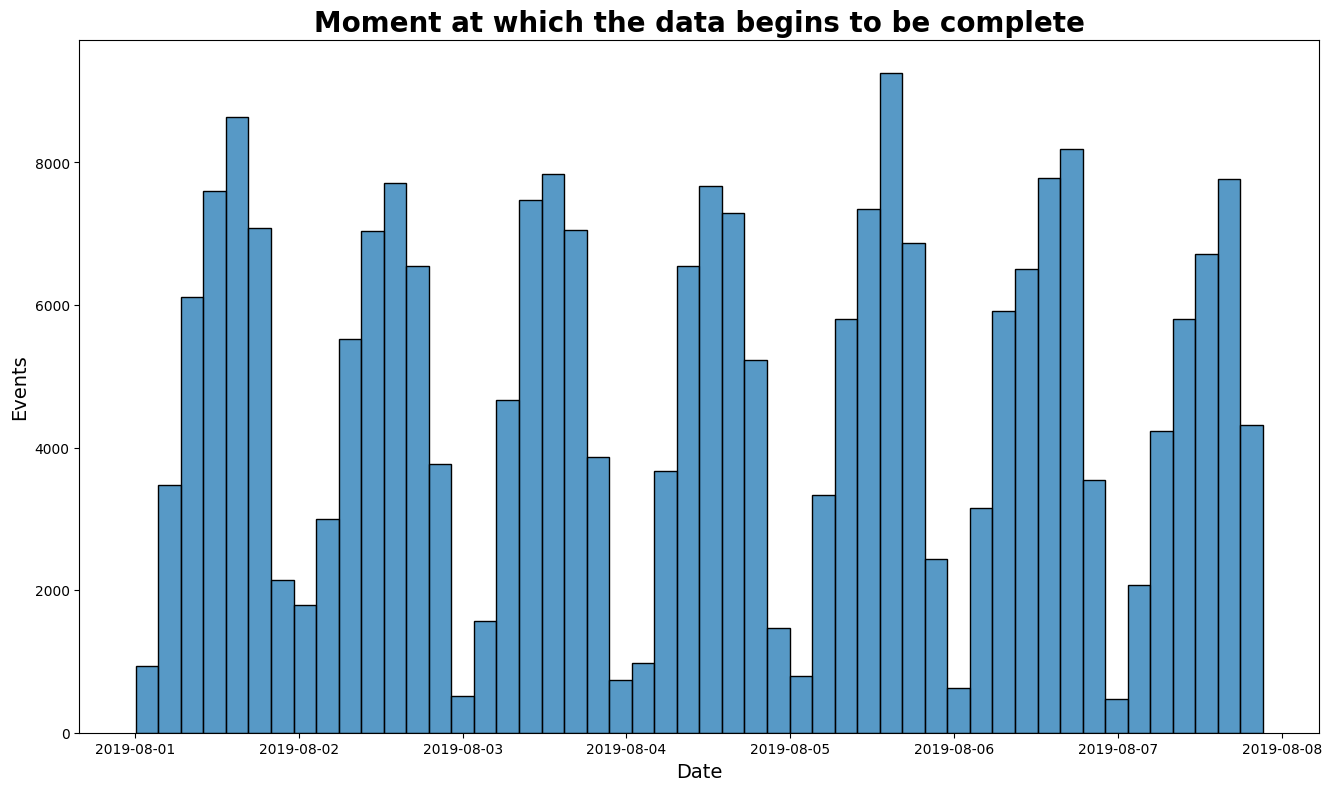

In [206]:
# Filtrar los datos a partir de la fecha en que los datos comienzan a estar completos
logs_experiment_with_complete_data = df_logs_experiment_clean[df_logs_experiment_clean['event_date'] 
                                                              >= complete_data_start_date]

# Graficar los datos con la librería Seaborn
plt.figure(figsize=(16, 9))
sns.histplot(logs_experiment_with_complete_data['event_timestamp'], bins=50, kde=False)
plt.title('Moment at which the data begins to be complete', fontsize=20, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.show()

**Conclusiones**

- En el histograma se puede ver  que hay una variabilidad diaria en la cantidad de eventos registrados.


- Los días 1, 5, 6 de Agosto tienen picos más altos de eventos, superando los 8000 eventos.


- Los días 2, 3, 4, 7 de Agosto se visualiza una menor cantidad de eventos en comparación con los otros días, con alrededor de 7000 eventos.


- La cantidad de eventos parecen seguir un patrón cíclico, con días alternos de mayor y menor cantidad de eventos.

# ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [207]:
# Calcular el número total de eventos y usuarios antes de la exclusión
total_events_before = logged_events['events'].sum()
total_users_before = logged_users['users'].sum()

print(f"El total de eventos antes de la exclusión: {total_events_before}")
print(f"El total de usuarios antes de la exclusión: {total_users_before}")

El total de eventos antes de la exclusión: 243713
El total de usuarios antes de la exclusión: 27226


In [208]:
# Calcular el número total de eventos y usuarios después de la exclusión
total_events_after = logs_experiment_with_complete_data['event_name'].count()
total_users_after = logs_experiment_with_complete_data['device_id_hash'].nunique()

print(f"El total de eventos después de la exclusión: {total_events_after}")
print(f"El total de usuarios después de la exclusión: {total_users_after}")

El total de eventos después de la exclusión: 240887
El total de usuarios después de la exclusión: 7534


In [209]:
# Calcular la diferencia de eventos y usuarios al excluir los datos más antiguos
events_lost = total_events_before - total_events_after
users_lost = total_users_before - total_users_after

print(f"La pérdida de eventos al excluir los datos más antiguos: {events_lost}")
print(f"La pérdida de usuarios al excluir los datos más antiguos: {users_lost}")

La pérdida de eventos al excluir los datos más antiguos: 2826
La pérdida de usuarios al excluir los datos más antiguos: 19692


In [210]:
# Calcular el número de usuarios pérdidos
users_per_event_lost = total_events_after / total_users_after
users_per_event_lost

31.97332094504911

In [211]:
# Calcular el porcentaje de usuarios pérdidos
percentage_lost_users = (users_per_event_lost / total_events_per_user) * 100
print(f"El porcentaje de usuarios pérdidos: {percentage_lost_users}")

El porcentaje de usuarios pérdidos: 0.15832295590517015


**Conclusión**

Un porcentaje tan bajo de pérdida de usuarios puede ser el indicio de que los usuarios están satisfectos con el servicio.

# Asegúrate de tener usuarios de los tres grupos experimentales.

In [212]:
# Calcular el número de usuarios únicos en cada grupo experimental a partir de los datos filtrados
users_per_experimental_group = logs_experiment_with_complete_data.groupby('exp_id')['device_id_hash'].nunique().reset_index()
users_per_experimental_group.columns = ['exp_id', 'unique_users']

In [213]:
# Imprimir los datos
users_per_experimental_group

,exp_id,unique_users
0,246,2484
1,247,2513
2,248,2537


In [214]:
# Verificar si hay usuarios de los tres grupos experimentales en los datos filtrados
all_experiments_covered = set(
    logs_experiment_with_complete_data['exp_id'].unique()) == set(users_per_experimental_group['exp_id'])
print(f"¿Hay usuarios de los tres grupos experimentales en los datos completos? {'Sí' if all_experiments_covered else 'No'}")

¿Hay usuarios de los tres grupos experimentales en los datos completos? Sí


**Paso 2. Estudiar el embudo de eventos**

# Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [215]:
# Contar la frecuencia de cada evento y cambiar el nombre a las columnas
event_frequencies = logs_experiment_with_complete_data['event_name'].value_counts().reset_index()
event_frequencies.columns = ['event_name', 'frequency']

In [216]:
# Ordenar los eventos por frecuencia en orden descendente
event_frequencies = event_frequencies.sort_values(by='frequency', ascending=False)

In [217]:
# Imprimir los datos
event_frequencies

,event_name,frequency
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


# Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [218]:
# Calcular la cantidad de usuarios únicos que realizaron cada acción
# Cambiar el nombre a las columnas
users_per_event = logs_experiment_with_complete_data.groupby('event_name')['device_id_hash'].nunique().reset_index()
users_per_event.columns = ['event_name', 'unique_users']

In [219]:
# Ordenar los eventos por el número de usuarios en orden descendente
users_per_event = users_per_event.sort_values(by='unique_users', ascending=False)

In [220]:
# Imprimir los datos
users_per_event

,event_name,unique_users
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [221]:
# Calcular la proporción de usuarios que realizaron la acción al menos una vez
total_unique_users = logs_experiment_with_complete_data['device_id_hash'].nunique()
users_per_event['user_proportion'] = (users_per_event['unique_users'] / total_unique_users) * 100

In [222]:
# Imprimir los datos
users_per_event

,event_name,unique_users,user_proportion
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


# ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

In [223]:
# Organizar los datos para obtener la secuencia de eventos
logs_experiment_with_complete_data = logs_experiment_with_complete_data.sort_values(by=['device_id_hash', 'event_timestamp'])

In [224]:
# Inicializar un diccionario para almacenar la transición de usuarios entre etapas
stage_transitions = {stage: 0 for stage in funnel_stages}

In [225]:
# Calcular la proporción de usuarios que pasan de un evento al siguiente
for i in range(len(funnel_stages) - 1):
    stage_current = funnel_stages[i]
    stage_next = funnel_stages[i + 1]
    
    # Obtener los usuarios únicos que realizaron la etapa actual y la siguiente
    users_current = logs_experiment_with_complete_data[
        logs_experiment_with_complete_data['event_name'] == stage_current]['device_id_hash'].unique()
    users_next = logs_experiment_with_complete_data[
        logs_experiment_with_complete_data['event_name'] == stage_next]['device_id_hash'].unique()
    
    # Contar la cantidad de usuarios que realizaron ambas etapas
    users_transition = len(set(users_current).intersection(users_next))
    stage_transitions[stage_current] = users_transition
    
    
    # Calcular la proporción de usuarios que pasan de una etapa a la siguiente
    transition_proportion = (users_transition / len(users_current)) * 100 if len(users_current) > 0 else 0
    print(f"Proporción de usuarios que pasan de {stage_current} a {stage_next}: {transition_proportion:.2f}%")

Proporción de usuarios que pasan de MainScreenAppear a OffersScreenAppear: 60.41%
Proporción de usuarios que pasan de OffersScreenAppear a CartScreenAppear: 80.10%
Proporción de usuarios que pasan de CartScreenAppear a PaymentScreenSuccessful: 94.64%
Proporción de usuarios que pasan de PaymentScreenSuccessful a Tutorial: 13.20%


In [226]:
# Imprimir la cantidad de usuarios que realizaron cada etapa y la transición entre etapas
stage_transitions

{'MainScreenAppear': 4482,
 'OffersScreenAppear': 3679,
 'CartScreenAppear': 3534,
 'PaymentScreenSuccessful': 467,
 'Tutorial': 0}

# Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [227]:
# Inicializar diccionarios para almacenar la cantidad de usuarios en cada etapa y la proporción de transición
stage_user_counts = {}
stage_proportions = {}

In [228]:
# Contar los usuarios en cada etapa del embudo
for stage in funnel_stages:
    user_count = logs_experiment_with_complete_data[
        logs_experiment_with_complete_data['event_name'] == stage]['device_id_hash'].nunique()
    stage_user_counts[stage] = user_count

In [229]:
# Calcular la proporción de usuarios que pasan de una etapa a la siguiente en relación con la etapa anterior
for i in range(len(funnel_stages) - 1):
    stage_current = funnel_stages[i]
    stage_next = funnel_stages[i + 1]

    # Cantidad de usuarios en la etapa actual
    users_in_current_stage = stage_user_counts[stage_current]

    # Cantidad de usuarios en la etapa siguiente que también estuvieron en la etapa actual
    users_in_next_stage = logs_experiment_with_complete_data[
        logs_experiment_with_complete_data['event_name'] == stage_next]['device_id_hash'].nunique()
    
    # Calcular la proporción de usuarios que pasan de la etapa actual a la siguiente
    if users_in_current_stage > 0:
        transition_proportion = (users_in_next_stage / users_in_current_stage) * 100
    else:
        transition_proportion = 0

    stage_proportions[f"{stage_current} → {stage_next}"] = transition_proportion
    print(f"Proporción de usuarios que pasan de {stage_current} a {stage_next}: {transition_proportion:.2f}%")

Proporción de usuarios que pasan de MainScreenAppear a OffersScreenAppear: 61.91%
Proporción de usuarios que pasan de OffersScreenAppear a CartScreenAppear: 81.30%
Proporción de usuarios que pasan de CartScreenAppear a PaymentScreenSuccessful: 94.78%
Proporción de usuarios que pasan de PaymentScreenSuccessful a Tutorial: 23.74%


In [230]:
# Imprimir la proporción de usuarios que pasan de una etapa a la siguiente
print("La proporción de usuarios que pasan de una etapa a la siguiente:")
print(stage_proportions)

La proporción de usuarios que pasan de una etapa a la siguiente:
{'MainScreenAppear → OffersScreenAppear': 61.908613020622724, 'OffersScreenAppear → CartScreenAppear': 81.29762682342695, 'CartScreenAppear → PaymentScreenSuccessful': 94.7777182645956, 'PaymentScreenSuccessful → Tutorial': 23.735518508053122}


# ¿En qué etapa pierdes más usuarios?

In [231]:
# Encontrar la etapa con la mayor pérdida de usuarios
max_loss_stage = min(stage_proportions, key=stage_proportions.get)
max_loss_value = stage_proportions[max_loss_stage]

print(f"La etapa con la mayor pérdida de usuarios es {max_loss_stage} con una pérdida del {100 - max_loss_value:.2f}%.")

La etapa con la mayor pérdida de usuarios es PaymentScreenSuccessful → Tutorial con una pérdida del 76.26%.


# ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

En el caso de esta última pregunta también correspondiente al paso 2 de este apartado no utilice el embudo de eventos definido al inicio del notebook porque es diferente al aquí declarado, en este caso, solo requiero las etapas que conforman el viaje desde su primer evento hasta el pago, y la etapa Tutorial no forma parte de ese ciclo. Finalmente cabe resaltar que el enfoque aquí es en las etapas críticas que conducen a una transacción exitosa.

In [232]:
# Definir las etapas del embudo relevantes para el viaje completo
funnel_stages = [
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

In [233]:
# Inicializar un conjunto con los usuarios que realizaron el primer evento de la secuencia
complete_journey_users = set(logs_experiment_with_complete_data[
    logs_experiment_with_complete_data['event_name'] == funnel_stages[0]
]['device_id_hash'].unique())

In [234]:
# Iterar sobre las etapas del embudo y encontrar la intersección de usuarios que completaron todas las etapas
for stage in funnel_stages[1:]:
    stage_users = set(logs_experiment_with_complete_data[
        logs_experiment_with_complete_data['event_name'] == stage
    ]['device_id_hash'].unique())
    complete_journey_users = complete_journey_users.intersection(stage_users)

In [235]:
# Calcular el número total de usuarios únicos y el porcentaje de usuarios que completaron el viaje completo
total_unique_users = logs_experiment_with_complete_data['device_id_hash'].nunique()
num_complete_journey_users = len(complete_journey_users)
percentage_complete_journey = (num_complete_journey_users / total_unique_users) * 100

print(f"El porcentaje de usuarios que completan todo el viaje desde su primer evento " 
      f"hasta el pago es: {percentage_complete_journey:.2f}%")

El porcentaje de usuarios que completan todo el viaje desde su primer evento hasta el pago es: 45.51%


**Paso 3. Estudiar los resultados del experimento**

# ¿Cuántos usuarios hay en cada grupo?

In [236]:
# Crear una tabla dinámica que muestre el número de usuarios que hay en cada grupo
users_in_each_group = logs_experiment_with_complete_data.pivot_table(
    index='exp_id', 
    values='device_id_hash',
    aggfunc='nunique',
)

In [237]:
# Cambiar el nombre a la columna
users_in_each_group.columns = ['number_users']

In [238]:
# Imprimir los datos de la tabla dinámica
users_in_each_group

,number_users
exp_id,
246,2484
247,2513
248,2537


**Conclusión**

La distribución de usuarios es bastante equilibrada entre los grupos de control y el grupo de prueba, lo cual es ideal para realizar un análisis justo y comparativo.

# Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [239]:
# Filtrar los datos para los grupos 246 y 247
group_246 = logs_experiment_with_complete_data[logs_experiment_with_complete_data['exp_id'] == 246]
group_247 = logs_experiment_with_complete_data[logs_experiment_with_complete_data['exp_id'] == 247]

# Seleccionar la métrica de interés para comparar entre los grupos (por ejemplo, número de eventos por usuario)
events_246 = group_246.groupby('device_id_hash').size()
events_247 = group_247.groupby('device_id_hash').size()

# Realizar la prueba t de Student para muestras independientes
t_statistic, p_value = stats.ttest_ind(events_246, events_247, equal_var=False)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretar los resultados
if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")

T-statistic: 0.7415177814595091
P-value: 0.4584152588842866
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.


**Conclusión**

No hay una diferencia estadísticamente significativa entre los grupos 246 y 247. Esto sugiere que los mecanismos y cálculos utilizados en el experimento A/A están funcionando correctamente, ya que no se espera una diferencia significativa entre los grupos de control en un test A/A. Esto confirma que ambos grupos se comportan de manera similar y cualquier diferencia observada es probablemente debido al azar en las muestras. 

# Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [240]:
# Crear una tabla dinámica que muestre el número de usuarios asociados a cada evento
users_in_each_associated_group = logs_experiment_with_complete_data.pivot_table(
    index='event_name', 
    columns='exp_id',
    values='device_id_hash',
    aggfunc='nunique',
)

In [241]:
# Imprimir los datos de la tabla dinámica
users_in_each_associated_group

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [242]:
# Seleccionar el evento más popular para cada grupo
most_popular_events_per_group = users_in_each_associated_group.idxmax()
numbers_per_most_popular_event = users_in_each_associated_group.max()

# Imprimir los datos
show_results = pd.DataFrame({
    'most_popular_event': most_popular_events_per_group,
    'number_users': numbers_per_most_popular_event
})

show_results

,most_popular_event,number_users
exp_id,,
246,MainScreenAppear,2450
247,MainScreenAppear,2476
248,MainScreenAppear,2493


In [243]:
# Generar una función para calcular el valor p y la estadística en desviaciones estándar de la distribución normal estándar
def hypothesis_test(successes_1, trials_1, successes_2, trials_2, alpha=0.01):
    
    # Asegurarse de que todos los parámetros sean floats simples no Series
    if isinstance(successes_1, pd.Series): successes_1 = float(successes_1.iloc[0])
    if isinstance(trials_1, pd.Series): trials_1 = float(trials_1.iloc[0])
    if isinstance(successes_2, pd.Series): successes_2 = float(successes_2.iloc[0])
    if isinstance(trials_2, pd.Series): trials_2 = float(trials_2.iloc[0])
    
    # Proporción de éxito en el primer grupo:
    proportion1 = successes_1 / trials_1
    
    # Proporción de éxito en el segundo grupo:
    proportion2 = successes_2 / trials_2
    
    # Proporción de éxito en el dataset unido:
    proportion_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
    
    # La diferencia entre las proporciones de los datasets
    difference = proportion1 - proportion2
    
    # Calcula la estadística en desviaciones estándar de la distribución normal estándar
    z_value = difference / mth.sqrt(proportion_combined * (1 - proportion_combined) * (1 / trials_1 + 1 / trials_2))
    
    # Establece la distribución normal estándar (media 0, desviación estándar 1)
    distribution = st.norm(0, 1)
    
    # Calcula el valor p
    p_value = (1 - distribution.cdf(abs(z_value))) * 2
        
    if p_value < alpha:
        print(f"alpha {alpha}: Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print(f"alpha {alpha}: No se pudo rechazar la hipótesis nula: "
              "no hay razón para pensar que las proporciones son diferentes")
    return 

In [244]:
# Generar una función para comparar el rendimiento de dos grupos para un evento y realiza una prueba de hipótesis entre ellas
def explore_hypotheses_events(group1, group2, event,
                              trials_table=users_in_each_group, users_per_group_event=users_in_each_associated_group):
    
    print(f'Para el evento {event} de los grupos {group1} y {group2}')
    successes_1 = users_per_group_event.loc[event, group1]
    trials_1 = trials_table.loc[group1]
    successes_2 = users_per_group_event.loc[event, group2]
    trials_2 =  trials_table.loc[group2]
    hypothesis_test(successes_1, trials_1, successes_2, trials_2)  

In [245]:
# Llamar a la función EXPLORE HYPOTHESES EVENTS una vez  
# Realizar la prueba de hipótesis entre diferentes combinaciones de grupos para cada evento
for evento in users_in_each_associated_group.index:
    explore_hypotheses_events(246, 247, evento)

Para el evento CartScreenAppear de los grupos 246 y 247
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento MainScreenAppear de los grupos 246 y 247
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento OffersScreenAppear de los grupos 246 y 247
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento PaymentScreenSuccessful de los grupos 246 y 247
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento Tutorial de los grupos 246 y 247
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


**Conclusiones**

- Los eventos seleccionados como más populares muestran una distribución balanceada entre los grupos 246 y 247, lo que es una señal positiva de que los grupos se divideron correctamente.


- Para cada uno de los eventos analizados, la prueba de hipótesis muestra que no hay diferencias estadísticamente significativas entre las proporciones de usuarios que realizaron dichos eventos en los grupos.


- El valor p en cada caso es mayor que el umbral de significancia α = 0.01, lo que lleva a no rechazar  la hipótesis nula.


- La ausencia de diferencias significativas en la realización de eventos entre los dos grupos de control indica que la división de los grupos fue correcta y homogénea. 

- Dado que los grupos de control son equivalentes en términos de comportamiento, se puede proceder a realizar pruebas A/B.

# Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [246]:
# Llamar a la función EXPLORE HYPOTHESES EVENTS dos veces  
# Realizar la prueba de hipótesis entre diferentes combinaciones de grupos para cada evento
for evento in users_in_each_associated_group.index:
    explore_hypotheses_events(246, 248, evento)
    explore_hypotheses_events(247, 248, evento)

Para el evento CartScreenAppear de los grupos 246 y 248
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento CartScreenAppear de los grupos 247 y 248
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento MainScreenAppear de los grupos 246 y 248
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento MainScreenAppear de los grupos 247 y 248
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento OffersScreenAppear de los grupos 246 y 248
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes
Para el evento OffersScreenAppear de los grupos 247 y 248
alpha 0.01: No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son

**Conclusiones**

- En todas las comparaciones realizadas entre el grupo con fuentes alteradas (248) y los grupos de control (246 y 247) para cada uno de los eventos, no se pudo rechazar la hipótesis nula. Esto significa que no hay diferencias estadísticamente significativas en las proporciones de usuarios que realizaron estos eventos.


- La consistencia observada sugiere que los grupos de control y el grupo con fuentes alteradas se comportan de manera similar en términos de participación en estos eventos específicos.


- La ausencia de diferencias significativas también valida el diseño experimental, lo que implica que cualquier cambio observado en futuros análisis podrá ser atribuido con mayor certeza a las intervenciones experimentales y no a la división original de los grupos.


- Dado que los resultados muestran que las proporciones de eventos son consistentes entre los grupos, se puede concluir que el experimento fue diseñado y ejecutado correctamente, proporcionando resultados fiables para futuras pruebas y análisis.

# ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

El nivel de significancia establecido para probar las hipótesis estadísticas realizadas anteriormente fue α = 0.01, pero eso no hace ninguna diferencia porque como se trabaja con muestras no hay certeza de que el "no rechazar la hipótesis sea lo correcto" sin importar que alpha se aplique 0.1, 0.05 o 0.01. Lo más importante es ser consciente de esto y tomar decisiones informadas sobre el nivel de riesgo aceptable en función del contexto y las implicaciones de los posibles errores. Al elegir diferentes valores de α, se esta ajustando nuestra tolerancia al riesgo de cometer un Error Tipo I. Valores más pequeños de α reducen la probabilidad de este tipo de error, pero a su vez, incrementan la probabilidad de cometer un Error Tipo II.

El número de pruebas de hipótesis estadísticas realizadas fueron 10:

Para cada evento, realice comparaciones entre los grupos:
 - Grupo 246 vs. Grupo 248
 - Grupo 247 vs. Grupo 248
 
Existen 5 eventos en total: 
 - CartScreenAppear

 - MainScreenAppear

 - OffersScreenAppear

 - PaymentScreenSuccessful

 - Tutorial
 
Para cada evento, realize 2 comparaciones de grupo.

Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. Mediante dos imagenes compruebo la aplicación del nivel de significancia estadística de 0.1 y los resultados que se obtuvieron.

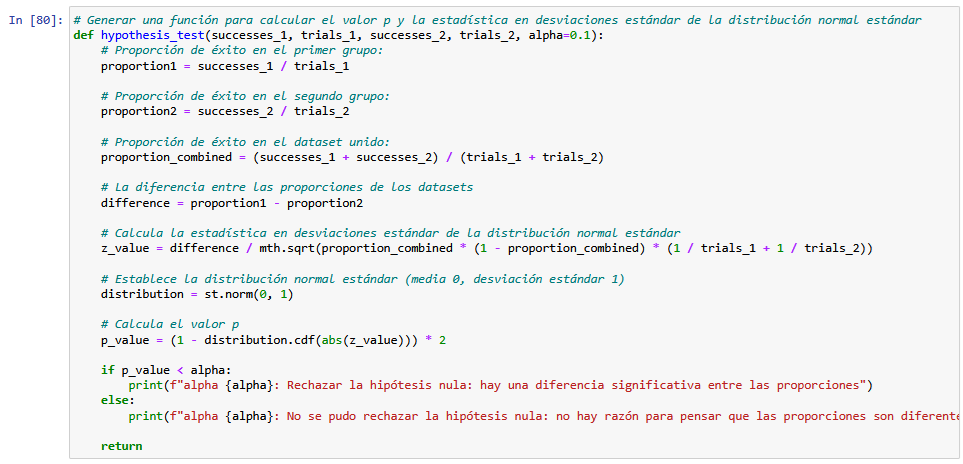

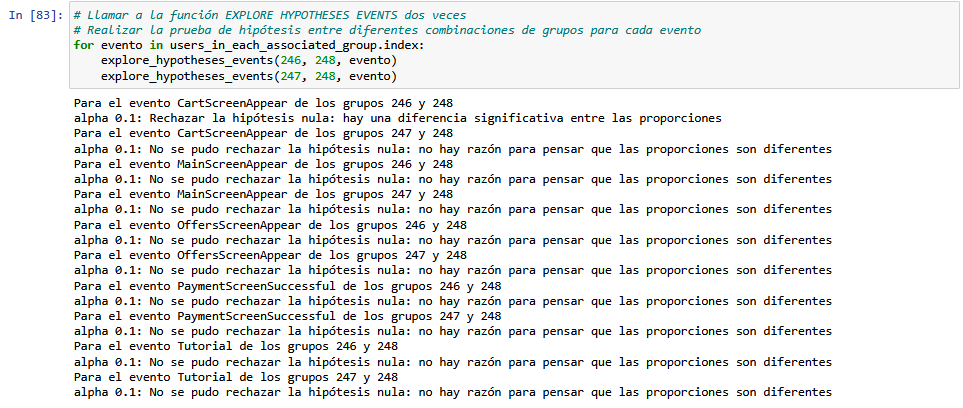

**Concluyó** que el realizar la prueba con un α=0.1 sugiere que hay una diferencia significativa en el evento CartScreenAppear entre los grupos 246 y 248. Y en el caso de las demás comparaciones, no hay evidencia de una diferencia significativa. Al utilizar un nivel de significancia α=0.1 aumenta la probabilidad de encontrar diferencias significativas donde podrían no existir realmente (falsos positivos). Por lo tanto, es importante considerar este factor al interpretar los resultados.

**¿Cuál debería ser el nivel de significancia?**

Para minimizar los **falsos positivos**, recomiendo utilizar un nivel de significancia más rígido, como α=0.05 o α=0.01. En el análisis inicial, utilicé α=0.01, lo que proporcionó resultados más conservadores y menos propensos a errores de Tipo I.


Aunque encontre una diferencia significativa en el evento CartScreenAppear con α=0.1, esta diferencia no fue significativa con α=0.01. Por lo que, la diferencia observada podría deberse al nivel de significancia más flojo y podría no ser una diferencia real.

**Conclusión**

Basado en un análisis más conservador (α=0.01), los grupos no muestran diferencias significativas en todos los eventos. Esto sugiere que las fuentes alteradas no tienen un efecto significativo sobre la participación del usuario.